In [1]:
from scipy.stats import weightedtau,kendalltau
from scipy import spatial
import pandas as pd
import numpy as np
import warnings
import random
import time
import copy

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('students_data.csv')
test_data = pd.read_csv('test_master.csv')

In [5]:
train_data.head(2)

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,1.0,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG4-FIXED,1.0,3(x+2) = 15,2005-09-09 12:24:35,2005-09-09 12:24:49,2005-09-09 12:25:15,2005-09-09 12:25:15,40.0,NaN,40.0,0.0,2.0,3.0,1.0,[SkillRule: Eliminate Parens; {CLT nested; CLT...,1
1,2.0,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG4-FIXED,1.0,x+2 = 5,2005-09-09 12:25:15,2005-09-09 12:25:31,2005-09-09 12:25:31,2005-09-09 12:25:31,16.0,16.0,NaN,1.0,0.0,0.0,1.0,"[SkillRule: Remove constant; {ax+b=c, positive...",1~~1


In [6]:
test_data.head(2)

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,390.0,0BrbPbwCMz,"Unit ES_04, Section ES_04-15",LIT59,1.0,b+r*(x+y) = v-s,2005-10-05 12:45:31,2005-10-05 12:45:46,2005-10-05 12:45:46,2005-10-05 12:45:46,15.0,15.0,NaN,1.0,0.0,0.0,1.0,"[SkillRule: Remove constant; {ax+b=c, positive...",77
1,717.0,0BrbPbwCMz,"Unit CTA1_10, Section CTA1_10-5",DIST05_SP,1.0,R7C1,2005-10-21 12:50:22,2005-10-21 12:50:28,2005-10-21 12:50:28,2005-10-21 12:50:28,6.0,6.0,NaN,1.0,0.0,0.0,1.0,"Using small numbers~~Find X, positive slope~~U...",36~~33~~33


# The EduRank Algorithm

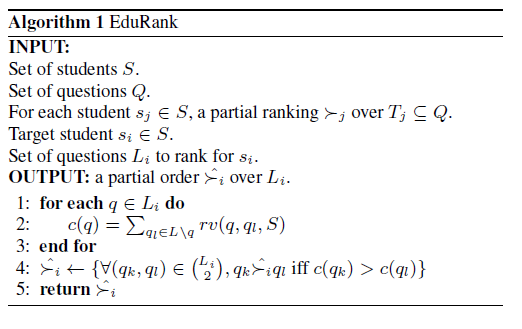

In [7]:
from IPython.display import Image
Image("edurank.png")

## Calculate Students Question Rankings

In [8]:
train_data['p_name'] =  [x + '_' + y for x,y in zip(train_data['Problem Name'].values,train_data['Step Name'].values)]

In [9]:
questions_hist = train_data[['p_name','Problem Name']].groupby('p_name').count()
rel_train_questions = questions_hist[questions_hist['Problem Name'].map(lambda d: d) > 1]
train_data['is_rel_question'] = [1 if x in rel_train_questions.index else 0 for x in train_data['p_name'].values]
rel_train_data = train_data[train_data['is_rel_question'] == 1]

In [10]:
%%time
# create a dictionary to store students rankings
rel_train_data['Incorrects'] = [0.0 if y == 1.0 else x for x,y in zip(rel_train_data['Incorrects'].values,rel_train_data['Correct First Attempt'].values)]
partial_rankings = {} 
for s in set(rel_train_data['Anon Student Id'].values):
    rel_questions = rel_train_data[rel_train_data['Anon Student Id'] == s].drop_duplicates(subset='p_name', keep='first')
    correct = rel_questions[rel_questions['Corrects'] != 0.0]
    correct_first = rel_questions[rel_questions['Correct First Attempt'] != 0.0]
    correct_not_first = correct[correct['Correct First Attempt'] == 0.0]
    incorrect = rel_questions[rel_questions['Corrects'] == 0.0]
    
    #sort questions by difficulty
    correct_first = correct_first.sort_values('Step Duration (sec)') #sort only by duration
    correct_not_first = correct_not_first.sort_values(['Incorrects','Step Duration (sec)']) #sort by trys and duration
    incorrect = incorrect.sort_values(['Incorrects','Step Duration (sec)']) #sort by trys and duration
    sorted_questins = pd.concat([correct_first,correct_not_first,incorrect]).drop_duplicates(subset='p_name', keep='first')
    
    #save questions ranking by student
    partial_rankings[s] = [x + '_' + y for x,y in zip(sorted_questins['Problem Name'].values,sorted_questins['Step Name'].values)]

Wall time: 42.3 s


In [11]:
print('max length:', max([len(x) for x in partial_rankings.values()]))
print('min length:', min([len(x) for x in partial_rankings.values()]))
print('mean length:', np.mean([len(x) for x in partial_rankings.values()]))
print('median length:', np.median([len(x) for x in partial_rankings.values()]))

max length: 6888
min length: 3
mean length: 1005.2787456445993
median length: 507.0


## Helper Functions

In [12]:
def get_k_score(k,s1,s2):
    rolling_sum = 0
    temp_element = s1[k]
    for q in s1[:k]: #for every question above k
        if q in s2 and temp_element in s2:
            rolling_sum = rolling_sum + 1 if s2.index(q) < s2.index(temp_element) else rolling_sum
        else:
            rolling_sum += 0.5
    return (1 / k) * rolling_sum


def get_ap_score(s1,s2): #s1: temp student, s2: reference student
    temp_intersct = set.intersection(set(s1),set(s2))
    is1 = [x for x in s1 if x in temp_intersct]
    is2 = [x for x in s2 if x in temp_intersct]
    rolling_sum = 0
    for k in range(1,len(is1)):
        rolling_sum += get_k_score(k,is1,is2)
    return (1 / (len(is1) -1)) * rolling_sum


def transform_rankings_to_numeric(partial_rankings, numeric_name_dic):
    numeric_partial_ranking = {}
    for k,v in partial_rankings.items():
        numeric_partial_ranking[k] = [numeric_name_dic[x] for x in v]
    return numeric_partial_ranking


def transform_predictions_to_string(predicted_order, numeric_name_dic):
    string_predicted_order = {}
    numeric_to_string_dic = {v:k for k,v in numeric_name_dic.items()}
    for k,v in predicted_order.items():
        string_predicted_order[k] = [numeric_to_string_dic[x] for x in v]
    return string_predicted_order


def get_weigted_k_tau_score(s1,s2):
    temp_intersct = set.intersection(set(s1),set(s2))
    is1 = [x for x in s1 if x in temp_intersct]
    is2 = [x for x in s2 if x in temp_intersct]
    return (weightedtau(is1,is2)[0] + 1) / 2


def get_k_tau_score(s1,s2):
    temp_intersct = set.intersection(set(s1),set(s2))
    is1 = [x for x in s1 if x in temp_intersct]
    is2 = [x for x in s2 if x in temp_intersct]
    return (kendalltau(is1,is2)[0] + 1) / 2

# Predicting Question Order

In [29]:
train_questions = set([x + '_' + y for x,y in zip(rel_train_data['Problem Name'].values,rel_train_data['Step Name'].values)])
test_data['p_name'] = [x + '_' + y for x,y in zip(test_data['Problem Name'].values,test_data['Step Name'].values)]

In [14]:
test_data.head(2)

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default),p_name
0,390.0,0BrbPbwCMz,"Unit ES_04, Section ES_04-15",LIT59,1.0,b+r*(x+y) = v-s,2005-10-05 12:45:31,2005-10-05 12:45:46,2005-10-05 12:45:46,2005-10-05 12:45:46,15.0,15.0,NaN,1.0,0.0,0.0,1.0,"[SkillRule: Remove constant; {ax+b=c, positive...",77,LIT59_b+r*(x+y) = v-s
1,717.0,0BrbPbwCMz,"Unit CTA1_10, Section CTA1_10-5",DIST05_SP,1.0,R7C1,2005-10-21 12:50:22,2005-10-21 12:50:28,2005-10-21 12:50:28,2005-10-21 12:50:28,6.0,6.0,NaN,1.0,0.0,0.0,1.0,"Using small numbers~~Find X, positive slope~~U...",36~~33~~33,DIST05_SP_R7C1


In [15]:
total_questions = [y for y in set([x for x in test_data.p_name.values])] + [y for y in set([x for x in rel_train_data.p_name.values])]
numeric_name_dic = {y:x for x,y in enumerate(sorted(total_questions))}
numeric_partial_rankings = transform_rankings_to_numeric(partial_rankings, numeric_name_dic)

In [16]:
%%time
predicted_order = {}
for s1 in set(test_data['Anon Student Id'].values):
    #get only relenant rows for the given student
    temp_df = test_data[test_data['Anon Student Id'] == s1]
    
    # if the student answerd only 1 question in the test set, rank the question as first
    if len(temp_df) == 1:
        predicted_order[s1] = [numeric_name_dic[temp_df['p_name'].iloc[0]]]
        continue
    # get all students who answerd the relenant questions from the test set
    temp_tupls = []
    temp_questions =  [numeric_name_dic[x] for x in temp_df['p_name'].values]
    for s2 in numeric_partial_rankings.keys():
        if s2 != s1:
            temp_tupls.append([s2,[x for x in numeric_partial_rankings[s2] if x in temp_questions]])
    temp_scores = pd.DataFrame(temp_tupls, columns =['s_id','rel_order'])
    
    #keep only students who answered more than 1 question 
    temp_scores = temp_scores[temp_scores['rel_order'].map(lambda d: len(d)) > 1]
    
    #get similarity scores for all relenavt students
    temp_scores['ap_score'] = [get_weigted_k_tau_score(numeric_partial_rankings[s1],numeric_partial_rankings[s3]) for s3 in temp_scores['s_id'].values]
    temp_scores = temp_scores.sort_values('ap_score', ascending=False)
    
    #calculate copeland's score for every question in the temporary test set
    final_temp_scores = []
    for q1 in temp_questions:
        temp_copeland_score = 0
        for q2 in temp_questions: #for every other question
            if q1 != q2:
                for index,row in temp_scores.iterrows(): #for every relevant student 
                    if q1 in row['rel_order'] and q2 in row['rel_order']: #the student ranked both questions
                        temp_sign = 1 if row['rel_order'].index(q1) > row['rel_order'].index(q2) else -1
                        temp_copeland_score += temp_sign * row['ap_score']
        final_temp_scores.append((q1,temp_copeland_score))
    predicted_order[s1] = [x[0] for x in sorted(final_temp_scores, key=lambda x: x[1])]

Wall time: 20min 34s


In [19]:
translated_predicted_order = transform_predictions_to_string(predicted_order,numeric_name_dic)

# Calculate True Test Rankings

In [20]:
%%time
# create a dictionary to store students rankings
test_data['Incorrects'] = [0.0 if y == 1.0 else x for x,y in zip(test_data['Incorrects'].values,test_data['Correct First Attempt'].values)]
true_test_rankings = {} 
i = 0
for s in set(test_data['Anon Student Id'].values):
    rel_questions = test_data[test_data['Anon Student Id'] == s].drop_duplicates(subset='p_name', keep='first')
    correct = rel_questions[rel_questions['Corrects'] != 0.0]
    correct_first = rel_questions[rel_questions['Correct First Attempt'] != 0.0]
    correct_not_first = correct[correct['Correct First Attempt'] == 0.0]
    incorrect = rel_questions[rel_questions['Corrects'] == 0.0]
    
    #sort questions by difficulty
    correct_first = correct_first.sort_values('Step Duration (sec)') #sort only by duration
    correct_not_first = correct_not_first.sort_values(['Incorrects','Step Duration (sec)']) #sort by trys and duration
    incorrect = incorrect.sort_values(['Incorrects','Step Duration (sec)']) #sort by trys and duration
    sorted_questins = pd.concat([correct_first,correct_not_first,incorrect]).drop_duplicates(subset='p_name', keep='first')
    
    #save questions ranking by student
    true_test_rankings[s] = [x for x in sorted_questins['p_name'].values]
    if len(rel_questions) != len(sorted_questins):
        print('problem!')
        break

Wall time: 9.2 s


## Results

In [21]:
total_ap_score = []
total_k_tau_score = []
total_w_k_tau_score = []
for key,val in true_test_rankings.items():
    temp_val = translated_predicted_order[key]
    if len(val) != 1:
        total_ap_score.append(get_ap_score(temp_val, val))
        translated_val = [numeric_name_dic[x] for x in val]
        translated_val = list(dict.fromkeys(translated_val))
        translated_temp_val = [numeric_name_dic[x] for x in temp_val]
        translated_temp_val = list(dict.fromkeys(translated_temp_val))
        total_w_k_tau_score.append(get_weigted_k_tau_score(translated_val, translated_temp_val))
        total_k_tau_score.append(get_k_tau_score(translated_val, translated_temp_val))
    else:
        total_ap_score.append(1)
        total_k_tau_score.append(1)
        total_w_k_tau_score.append(1)

In [22]:
print('AP Rank Correlation')
print('mean:', np.mean(total_ap_score))
print('median:', np.median(total_ap_score))

print('Kendalls tau')
print('mean:', np.mean(total_k_tau_score))
print('median:', np.median(total_k_tau_score))

print('Weighted Kendalls tau')
print('mean:', np.mean(total_w_k_tau_score))
print('median:', np.median(total_w_k_tau_score))

AP Rank Correlation
mean: 0.6808166755309746
median: 0.6777777777777777
Kendalls tau
mean: 0.6122126658523862
median: 0.5904761904761905
Weighted Kendalls tau
mean: 0.6135679256594797
median: 0.6


# Improvements

- Until now we only used the ordering of question answered by a pair of students as a similarity measure.
- In this section we will try to use the similarity between students based on their overall performance and incorperate this information in the EduRank algorithm. 


In [23]:
temp_train_data = copy.deepcopy(train_data)
temp_train_data['Corrects'] = [0 if x == 0 else 1 for x in temp_train_data['Corrects'].values] #make sure a student is correct only once
performance_stats = temp_train_data[['Incorrects','Hints','Corrects','Correct First Attempt','Step Duration (sec)','Correct Step Duration (sec)','Error Step Duration (sec)','Anon Student Id']].groupby('Anon Student Id').mean()

In [28]:
performance_stats.head()

,Incorrects,Hints,Corrects,Correct First Attempt,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec)
Anon Student Id,,,,,,,
02ZjVTxC34,0.628338,0.587537,0.933234,0.641691,38.671910,20.997677,70.776371
02i5jCrfQK,0.401262,0.335137,0.962579,0.777127,17.770694,11.778900,39.412632
0493L6bGa9,0.407240,0.305430,0.986425,0.760181,35.432127,27.919643,59.245283
04N6FdP4pd,0.679279,0.290090,0.951351,0.774775,30.367347,21.922717,62.562500
075kbY53c1,0.857399,0.489968,0.944106,0.640272,29.682520,16.085618,54.004505


In [24]:
normalized_stats=(performance_stats-performance_stats.min())/(performance_stats.max()-performance_stats.min())
normalized_stats.head()

,Incorrects,Hints,Corrects,Correct First Attempt,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec)
Anon Student Id,,,,,,,
02ZjVTxC34,0.267863,0.271171,0.551717,0.570030,0.234848,0.158586,0.243206
02i5jCrfQK,0.171060,0.154679,0.748744,0.732552,0.078561,0.077109,0.120997
0493L6bGa9,0.173608,0.140968,0.908856,0.712217,0.210623,0.219763,0.198275
04N6FdP4pd,0.289579,0.133888,0.673359,0.729730,0.172752,0.166762,0.211201
075kbY53c1,0.365512,0.226139,0.624712,0.568327,0.167631,0.115172,0.177854


In [25]:
%%time
predicted_order = {}
for s1 in set(test_data['Anon Student Id'].values):
    #get only relenant rows for the given student
    temp_df = test_data[test_data['Anon Student Id'] == s1]
    
    # if the student answerd only 1 question in the test set, rank the question as first
    if len(temp_df) == 1:
        predicted_order[s1] = [numeric_name_dic[temp_df['p_name'].iloc[0]]]
        continue
    # get all students who answerd the relenant questions from the test set
    temp_tupls = []
    temp_questions =  [numeric_name_dic[x] for x in temp_df['p_name'].values]
    for s2 in numeric_partial_rankings.keys():
        if s2 != s1:
            temp_tupls.append([s2,[x for x in numeric_partial_rankings[s2] if x in temp_questions]])
    temp_scores = pd.DataFrame(temp_tupls, columns =['s_id','rel_order'])
    
    #keep only students who answered more than 1 question 
    temp_scores = temp_scores[temp_scores['rel_order'].map(lambda d: len(d)) > 1]
    
    #get similarity scores for all relenavt students
    temp_scores['ap_score'] = [get_weigted_k_tau_score(numeric_partial_rankings[s1],numeric_partial_rankings[s3]) for s3 in temp_scores['s_id'].values]
    #get similarity score based on students performance
    temp_scores['performnc_sim_score'] = [1 - spatial.distance.cosine(list(normalized_stats.loc[s1]),list(normalized_stats.loc[s3])) for s3 in temp_scores['s_id'].values]
    
    #normalize score
    temp_scores['performnc_sim_score'] = (temp_scores['performnc_sim_score'] - temp_scores['performnc_sim_score'].min()) / (temp_scores['performnc_sim_score'].max() - temp_scores['performnc_sim_score'].min())
    #normalize ap
    temp_scores['ap_score'] = (temp_scores['ap_score'] - temp_scores['ap_score'].min()) / (temp_scores['ap_score'].max() - temp_scores['ap_score'].min())

    #calculate copeland's score for every question in the temporary test set
    final_temp_scores = []
    for q1 in temp_questions:
        temp_copeland_score = 0
        for q2 in temp_questions: #for every other question
            if q1 != q2:
                for index,row in temp_scores.iterrows(): #for every relevant student 
                    if q1 in row['rel_order'] and q2 in row['rel_order']: #the student ranked both questions
                        temp_sign = 1 if row['rel_order'].index(q1) > row['rel_order'].index(q2) else -1
                        temp_copeland_score += temp_sign * (0.8 * row['ap_score'] + 0.2 * row['performnc_sim_score'])
        final_temp_scores.append((q1,temp_copeland_score))
    predicted_order[s1] = [x[0] for x in sorted(final_temp_scores, key=lambda x: x[1])]

Wall time: 20min 24s


In [26]:
translated_predicted_order = transform_predictions_to_string(predicted_order,numeric_name_dic)

In [27]:
total_ap_score = []
total_k_tau_score = []
total_w_k_tau_score = []
for key,val in true_test_rankings.items():
    temp_val = translated_predicted_order[key]
    if len(val) != 1:
        total_ap_score.append(get_ap_score(temp_val, val))
        translated_val = [numeric_name_dic[x] for x in val]
        translated_val = list(dict.fromkeys(translated_val))
        translated_temp_val = [numeric_name_dic[x] for x in temp_val]
        translated_temp_val = list(dict.fromkeys(translated_temp_val))
        total_w_k_tau_score.append(get_weigted_k_tau_score(translated_val, translated_temp_val))
        total_k_tau_score.append(get_k_tau_score(translated_val, translated_temp_val))
    else:
        total_ap_score.append(1)
        total_k_tau_score.append(1)
        total_w_k_tau_score.append(1)
        
print('AP Rank Correlation')
print('mean:', np.mean(total_ap_score))
print('median:', np.median(total_ap_score))

print('Kendalls tau')
print('mean:', np.mean(total_k_tau_score))
print('median:', np.median(total_k_tau_score))

print('Weighted Kendalls tau')
print('mean:', np.mean(total_w_k_tau_score))
print('median:', np.median(total_w_k_tau_score))

AP Rank Correlation
mean: 0.678030678338647
median: 0.6805555555555555
Kendalls tau
mean: 0.604045309666248
median: 0.575
Weighted Kendalls tau
mean: 0.6065472267499759
median: 0.5909090909090908
